# Discord messenger

In [36]:
import nest_asyncio
nest_asyncio.apply()
import discord
from discord.ext import tasks, commands
from datetime import datetime
import json

from binance.client import Client
from binance.enums import * #https://github.com/sammchardy/python-binance/blob/master/binance/enums.py

def get_api_keys(site: str, api_type: str)->str:
    """
    gets api keys stored in api-keys/api-keys.txt
    site: 'binance'
    api_type: 'api', 'secret'
    """
    with open('../api-keys/api-keys.txt') as json_file:
        return json.load(json_file)[site][api_type]
# Constants
dtoken = get_api_keys("discord", "api")

bot = commands.Bot(command_prefix="-")

api_key = get_api_keys("binance", "api")
api_secret = get_api_keys("binance", "secret")

client = Client(api_key=api_key, api_secret=api_secret)

## FOR MATPLOTLIB PLOTTING

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vm

def create_plot(a="CELR", b="FET", base="USDT", past=2000):
    """create matplotlib plot"""

    df1 = pd.read_csv(f"../data/{a}{base}-past.csv", index_col=0, parse_dates=True)
    df2 = pd.read_csv(f"../data/{b}{base}-past.csv", index_col=0, parse_dates=True)

    df = df1.open.rename("A").to_frame()
    df["B"] = df2.open

    df = df[4000:]
    df = df.dropna()
    
    results = sm.ols(formula="B ~ A", data=df[['B', 'A']]).fit()
    hedgeRatio = results.params[1]
    
    spread = pd.Series((df['B'] - hedgeRatio * df['A'])).rename("spread").to_frame()
    spread["mean"] = spread.spread.rolling(2000).mean()
    spread["std"] =  spread.spread.rolling(2000).std()
    spread["zscore"] = pd.Series((spread["spread"]-spread["mean"])/spread["std"])
    
    spread = spread.dropna()
    
    spread["A"] = df1["close"].reindex(spread.index)
    spread["Ah"] = df1["high"].reindex(spread.index)
    spread["Al"] = df1["low"].reindex(spread.index)

    spread["B"] = df2["close"].reindex(spread.index)
    spread["Bh"] = df2["high"].reindex(spread.index)
    spread["Bl"] = df2["low"].reindex(spread.index)
    
    spread.index = (range(len(spread)))
    
    def get_a_b(al, ac, ah, bl, bc, bh):
        return ac-abs(ac-al)/2, ac+abs(ac-ah)/2, bc-abs(bc-bl)/2, bc+abs(bc-bh)/2
    
    total = 100.
    fee = 0.002       #Set double normal rate
    thres = 1.        #2
    sell_thres = 1.   # 0, in range [0, ...) for more travel
    cusum = []
    price_a = None
    price_b = None
    long = None       #Values: None, "A", "B"
    long_a = []
    long_b = []
    liquidate = []
    test = []
    trades = 0
    for i in range(spread.shape[0]):
        z = spread.zscore[i]
        if long == None: # Looking to buy
            if z>thres or z<-thres:
                trades += 1
                al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
                if z>thres: 
                    price_a = [ah, ((total/2)/ah)*(1.-fee)]
                    price_b = [bl, ((total/2)/bl)*(1.-fee)]
                    long = "A"
                    long_a.append(spread.index[i])
                elif z<-thres:
                    price_a = [al, ((total/2)/al)*(1.-fee)]
                    price_b = [bh, ((total/2)/bh)*(1.-fee)]
                    long = "B"
                    long_b.append(spread.index[i])
        if long == "B" and z>sell_thres: #Liquidate positions
            al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
            total += (price_a[0] - ah)*price_a[1]-(ah*price_a[1]*fee)
            total += (bl - price_b[0])*price_b[1]-(bl*price_b[1]*fee)
            price_a, price_b, long = None, None, None
            liquidate.append(spread.index[i])
        elif long == "A" and z<-sell_thres: #Liquidate positions
            al, ah, bl, bh = get_a_b(spread.Al[i], spread.A[i], spread.Ah[i], spread.Bl[i], spread.B[i], spread.Bh[i])
            total += (al - price_a[0])*price_a[1]-(al*price_a[1]*fee)
            total += (price_b[0] - bh)*price_b[1]-(bh*price_b[1]*fee)
            price_a, price_b, long = None, None, None
            liquidate.append(spread.index[i])
        cusum.append(total)
        
    plot = spread
    plot["cusum"] = cusum

    s = list(pd.Series(cusum).diff())
    s = pd.Series(s, index=spread.index)
    plot["diffs"] = s[s != 0.]


    plot = plot[-past:] #500_000:700_000

    fig, (ax, axz, axc) = plt.subplots(3, figsize=(12,9))

    # close_df.loc['2014':].plot(ax=ax, alpha=.5)
    ax.plot(plot.A, alpha=.7, color="lightblue", label="A")
    ax1 = ax.twinx()
    ax1.plot(plot.B, alpha=.5, color="orange", label="B")


    ax.plot(plot.A.reindex(long_a), marker='^', markersize=7,
                         alpha=0.75, color='blue', linewidth=0)

    ax.plot(plot.A.reindex(long_b), marker='v', markersize=7,
                         alpha=0.75, color='blue', linewidth=0)

    ax1.plot(plot.B.reindex(long_b), marker='^', markersize=7,
                         alpha=0.75, color='red', linewidth=0)

    ax1.plot(plot.B.reindex(long_a), marker='v', markersize=7,
                         alpha=0.75, color='red', linewidth=0)
    ax.plot(plot.A.reindex(liquidate), marker='o', markersize=7,
                         alpha=0.75, color='gray', linewidth=0)
    ax1.plot(plot.B.reindex(liquidate), marker='o', markersize=7,
                         alpha=0.75, color='gray', linewidth=0)
    ax2 = ax.twinx()
    ax2.plot(plot.cusum, color="gray", alpha=.5)
    ax.legend()
    ax1.legend()

    axz.plot(plot.zscore, color="gray", alpha=.5, label="zscore")
    axz.plot(plot.zscore.reindex(long_a), marker='o', markersize=7,
                         alpha=0.75, label='long_a', color='lightblue', linewidth=0)
    axz.plot(plot.zscore.reindex(long_b), marker='o', markersize=7,
                         alpha=0.75, label='long_b', color='orange', linewidth=0)
    axz.plot(plot.zscore.reindex(liquidate), marker='o', markersize=7,
                         alpha=0.75, label='liquidate', color='gray', linewidth=0)

    axz.legend()

    axc.scatter(plot.index, plot.diffs[plot.diffs > 0].reindex(plot.index)*100/plot.cusum, color="green", alpha=.5)
    axc.scatter(plot.index, plot.diffs[plot.diffs <= 0].reindex(plot.index)*100/plot.cusum, color="red", alpha=.5)
    axc.axhline(0, linestyle="--", color="blue", alpha=.5)
    axc1 = axc.twinx()
    axc1.plot(plot.cusum, color="gray", alpha=.5)
    
    fig.savefig('plot.png')

    

In [38]:
messages = {"message":"", "o_l":"", "o_s":""}
def get_message(message:str):
    global messages
    """gets the message"""
    with open('message.txt') as json_file:
        new_message = json.load(json_file)[message]
        try: #Basically, sometimes if you don't need to limit rate
            if messages[message] == new_message: #Same message
                return ""
            elif messages[message] == "": #Haven't updated
                messages[message] = new_message
                return ""
            messages[message] = new_message
        except:
            pass
        return new_message

Logged in


RuntimeError: Cannot close a running event loop

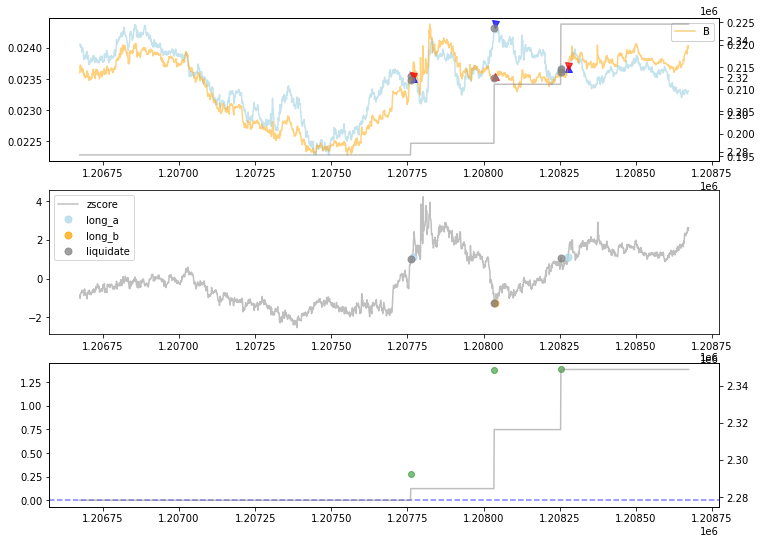

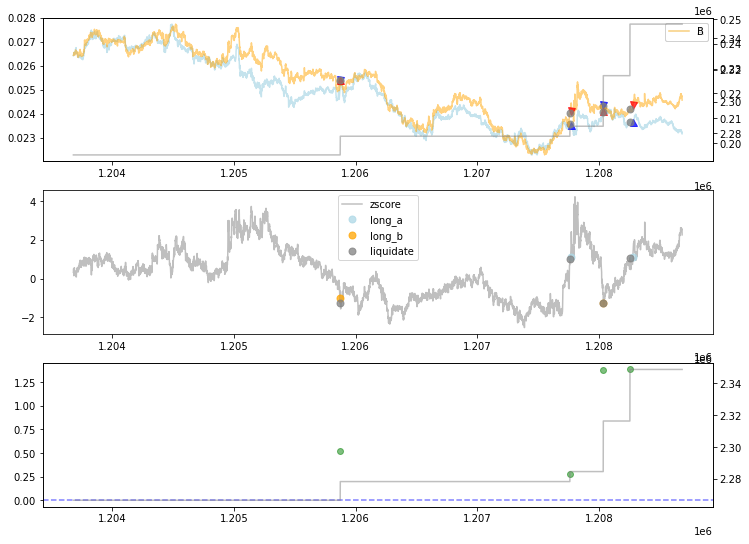

In [39]:
@bot.event
async def on_ready():
    print("Logged in")
    updater.start()


@tasks.loop(seconds=60)
async def updater():
    noti = bot.get_channel(853110820611555328)
    announcements = bot.get_channel(864949029623169044)
#     await channel.send(str(datetime.today()))
    try:
        await announcements.send(get_message("message"))
    except:
        pass
    try:
        await noti.send(get_message("o_l"))
    except:
        pass
    try:
        await noti.send(get_message("o_s"))
    except:
        pass
    
@bot.command()
async def asset(message, asset=""):
    '''Returns isolated margin account for that asset'''
    try:
        reply = "-------------------------\n"
        a = get_isolated_margin_account(asset.upper())
        for item in a["baseAsset"]:
            if item in ["asset", "borrowed", "free", "interest", "netAsset"]:
                reply = reply + f"{item}: {a['baseAsset'][item]}\n"
        reply = reply + "-------------------------\n"
        for item in a["quoteAsset"]:
            if item in ["asset", "free"]:
                reply = reply + f"{item}: {a['quoteAsset'][item]}\n"
        await message.channel.send(reply)
    except:
        await message.channel.send("There are no positions with that asset")
        
        
@bot.command()
async def mode(message):
    '''Returns current printer mode, which corresponds to printer refersh rate'''
    await message.channel.send(f"Current mode is : {get_message('mode')}")
    
@bot.command()
async def z(message):
    '''Returns current z-score'''
    await message.channel.send(f"Latest z-score: {str(round(float(get_message('z')), 2))}")
    
@bot.command()
async def analyze(message, a="CELR", b="FET", past=2000):
    """Plots analysis"""
    create_plot(a, b, "USDT", past)
    await message.channel.send(file=discord.File('plot.png'))

@bot.command()
async def level(message, asset=""):
    """Get current margin level of asset, where 2 or greater is safe"""
    get_isolated_margin_account("FET")
    if asset == "":
        await message.channel.send(f"Current margin level is {client.get_margin_account()['marginLevel']}")
    else:
        try:
            await message.channel.send(f"Current margin level for {asset.upper()} is {get_isolated_margin_account(asset.upper())['marginLevel']}")
        except:
            await message.channel.send(f"Margin level does not exist for asset {asset.upper()}")
    
@bot.command()
async def position(message, asset="", quote="USDT"):
    """Get position for asset with quote="USDT". ASSUMES there is an ongoing trade"""
    trade = 0 #Price that I traded the asset for
    price = 0
    percent = 0
    pair = asset.upper() + quote.upper()
    side = ""
    try:
        price = round(get_price(pair), 5) #Current price
        position = client.get_margin_trades(symbol=pair, isIsolated='TRUE')[-1]
        trade = round(float(position["price"]), 5)
        if position["isBuyer"]:
            side = "Long"
            percent = round((price-trade)*100/trade, 2)
        else:
            side = "Short"
            percent = round((trade-price)*100/trade, 2)    
        await message.channel.send(f"{side} {asset.upper()}: Trade price: {str(trade)}, now: {str(price)}, current change: {str(percent)}%")
    except:
        await message.channel.send(f"Unfortuately cannot find position for {pair}")

@updater.before_loop
async def before():
    await bot.wait_until_ready()
    
def get_price(symbol:str):
    """returns the price. symbol MUST include USDT, ie ZECUSDT"""
    return float(client.get_recent_trades(symbol=symbol, limit=1)[0]["price"])

def get_isolated_margin_account(base_asset: str):
    """Returns dict for isolated margin account for base_asset. Enter base_asset as 'FET'. Do NOT include USDT"""
    c = client.get_isolated_margin_account()
    return list(filter(lambda x: x["baseAsset"]["asset"] == base_asset, c["assets"]))[0]

bot.run(dtoken)